In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   model                9 non-null      object 
 1   num_parameters       9 non-null      float64
 2   num_requests         9 non-null      int64  
 3   TP                   9 non-null      int64  
 4   PP                   9 non-null      int64  
 5   mfu_mean             9 non-null      float64
 6   average_power_watts  9 non-null      float64
 7   peak_power_watts     9 non-null      float64
 8   total_energy_kwh     9 non-null      float64
 9   tokens_per_second    9 non-null      float64
 10  requests_per_second  9 non-null      float64
 11  latency_95p          9 non-null      float64
 12  execution_time_s     9 non-null      float64
dtypes: float64(9), int64(3), object(1)
memory usage: 1.0+ KB
None

First few rows:
                                 model  num_

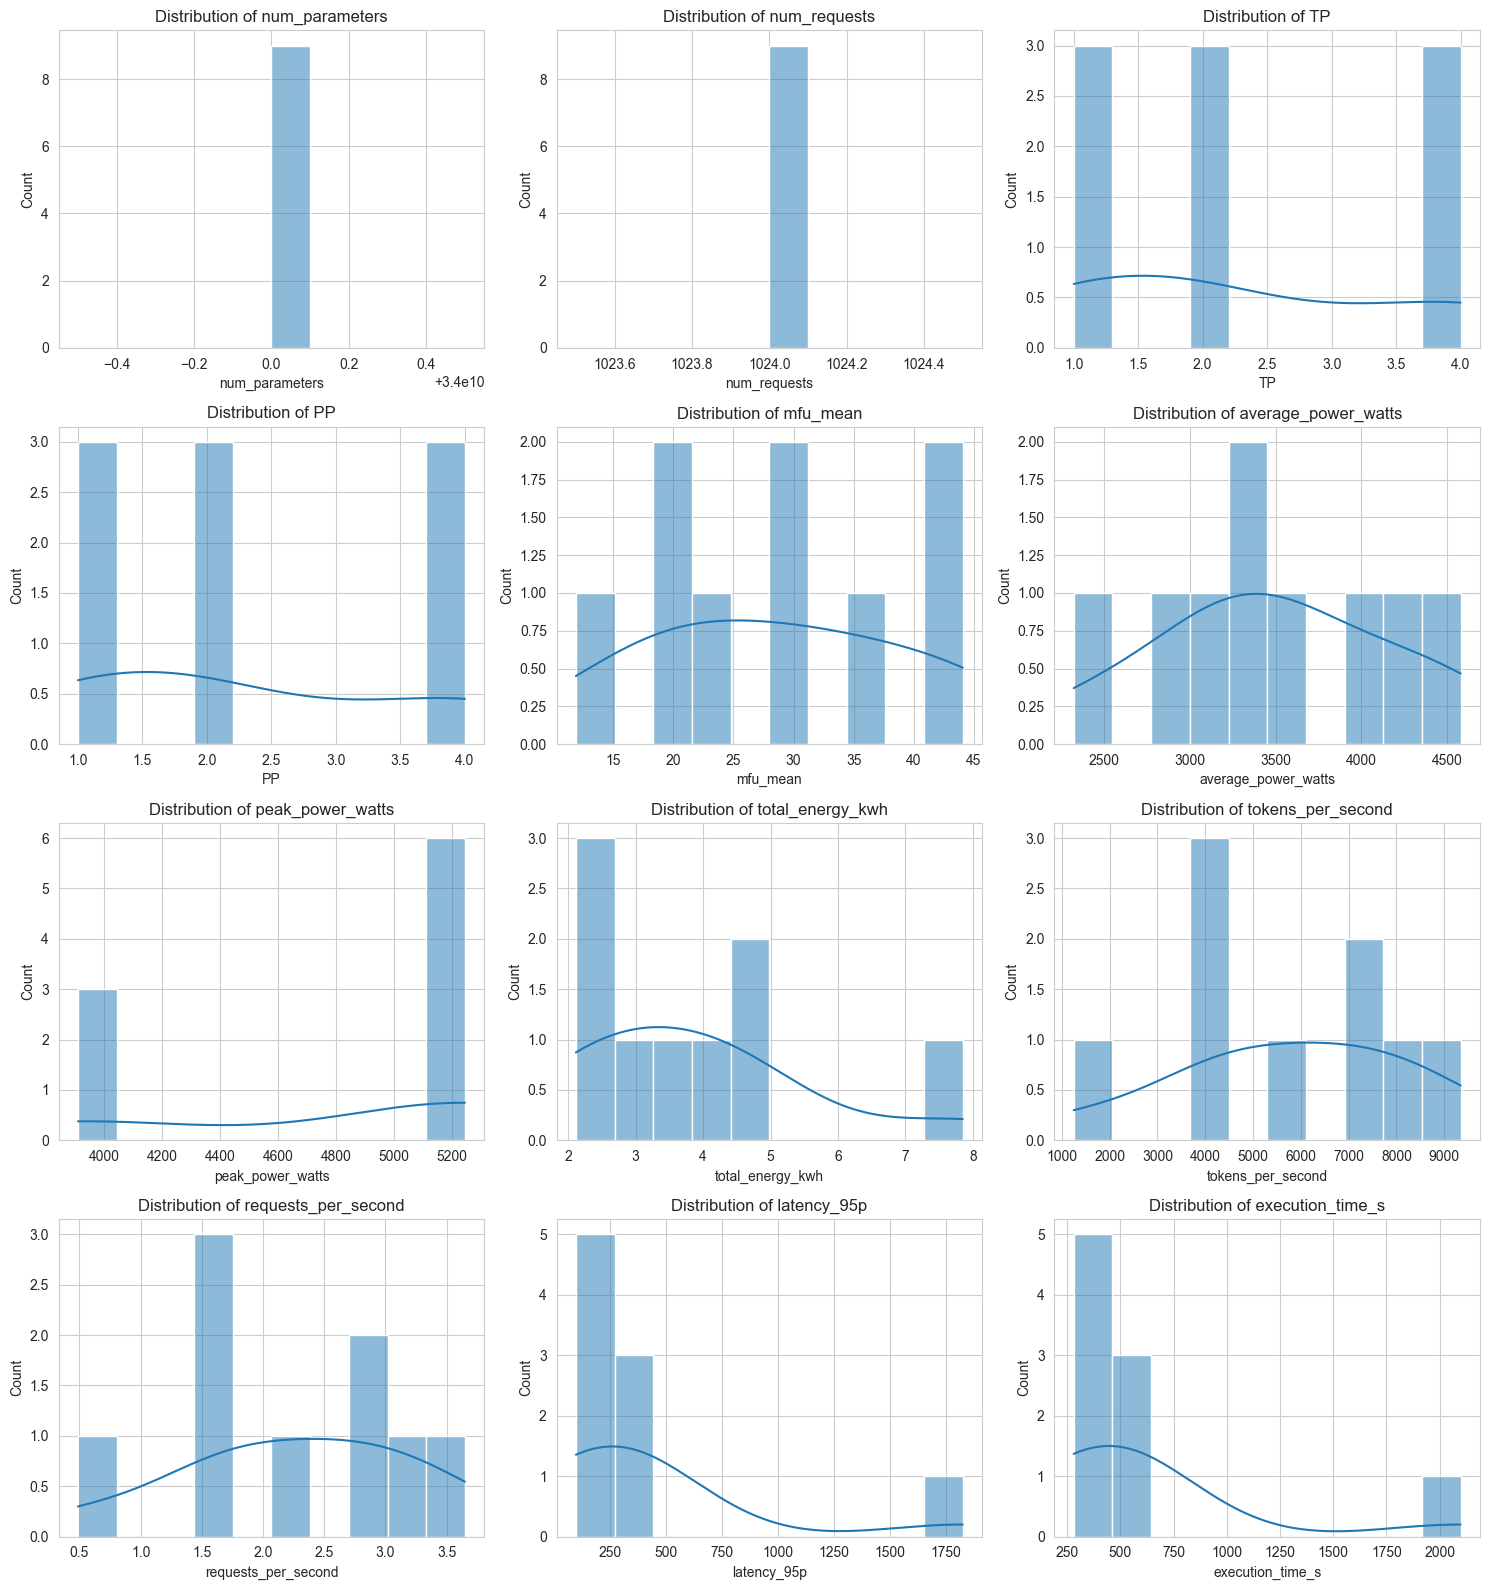

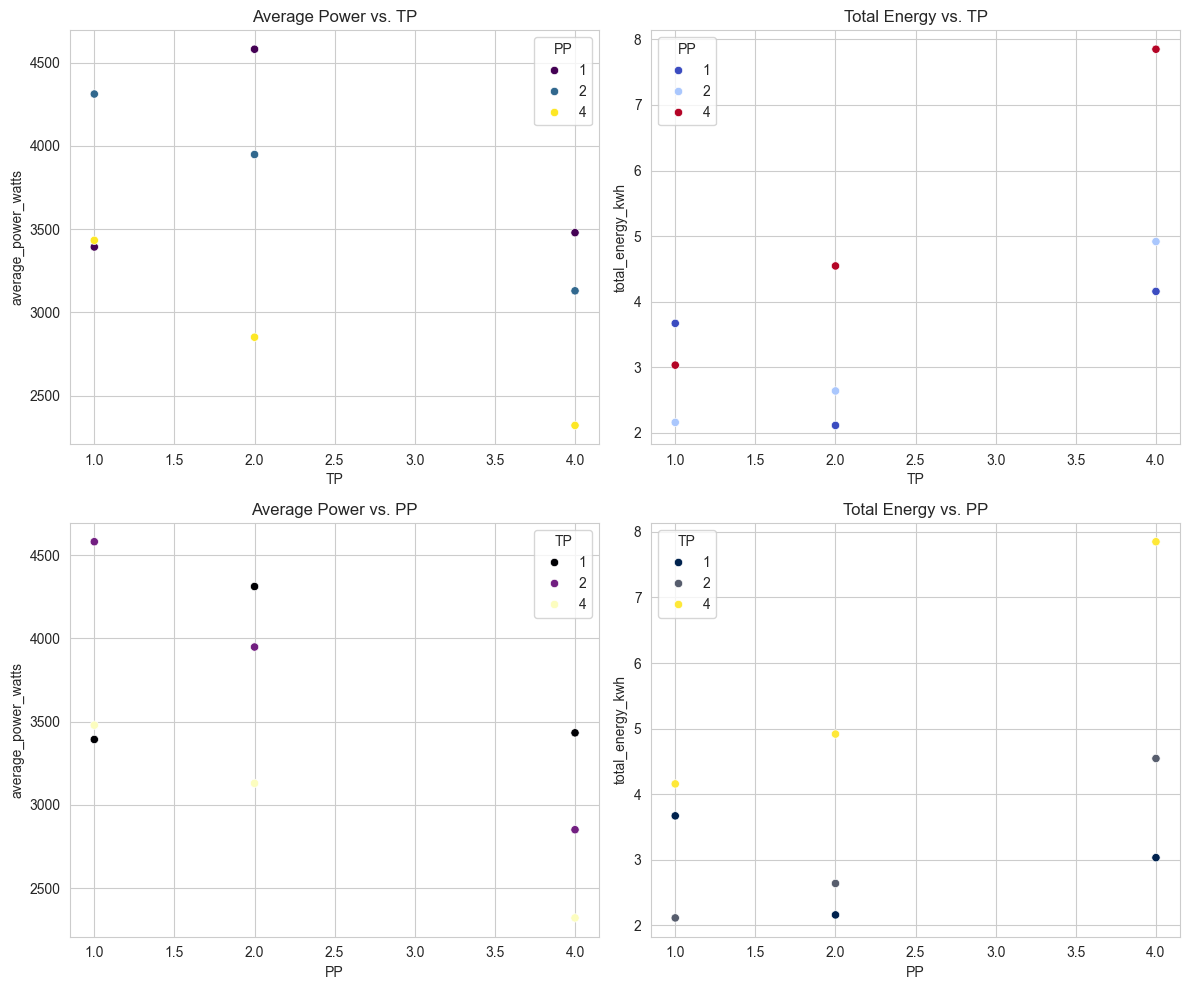

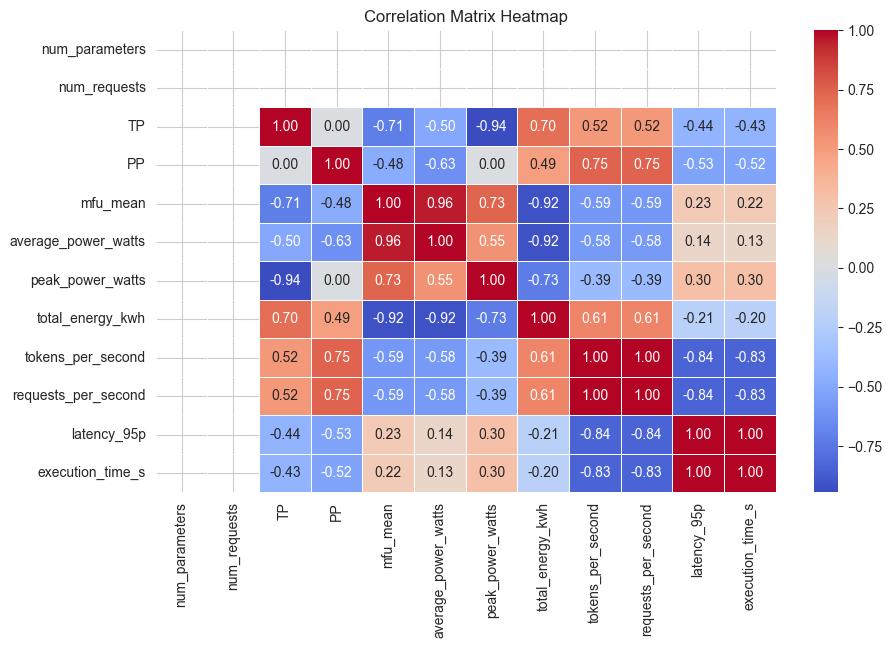

In [2]:
# Load the dataset
file_path = "/Users/mirayozcan/Desktop/vidur_copy/vidur/simulator_output/exp5-parallelism-power-lenergy/experiment_results_summary.csv"
df = pd.read_csv(file_path)

# Display basic info
print("Dataset Information:")
print(df.info())

# Display first few rows
print("\nFirst few rows:")
print(df.head())

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Pairwise correlation (only numeric columns)
print("\nCorrelation Matrix:")
print(df.select_dtypes(include=[np.number]).corr())

# Set up visualizations
sns.set_style("whitegrid")

# Dynamically select numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Dynamically set the number of rows for the grid
num_plots = len(num_cols)
num_cols_per_row = 3
num_rows = (num_plots // num_cols_per_row) + (num_plots % num_cols_per_row > 0)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(15, num_rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=10, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

# Hide unused subplots if any
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Scatter plots for key relationships
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Power vs. TP
sns.scatterplot(data=df, x="TP", y="average_power_watts", hue="PP", palette="viridis", ax=axes[0, 0])
axes[0, 0].set_title("Average Power vs. TP")

# Energy vs. TP
sns.scatterplot(data=df, x="TP", y="total_energy_kwh", hue="PP", palette="coolwarm", ax=axes[0, 1])
axes[0, 1].set_title("Total Energy vs. TP")

# Power vs. PP
sns.scatterplot(data=df, x="PP", y="average_power_watts", hue="TP", palette="magma", ax=axes[1, 0])
axes[1, 0].set_title("Average Power vs. PP")

# Energy vs. PP
sns.scatterplot(data=df, x="PP", y="total_energy_kwh", hue="TP", palette="cividis", ax=axes[1, 1])
axes[1, 1].set_title("Total Energy vs. PP")

plt.tight_layout()
plt.show()

# Heatmap for correlations
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

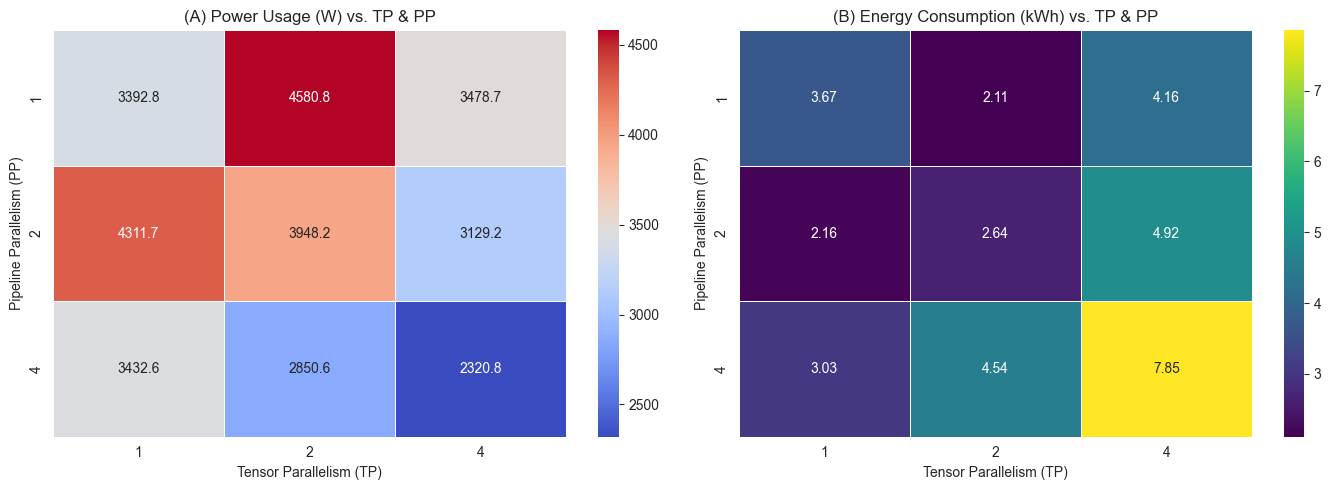

In [3]:
# Pivot data for heatmaps
power_pivot = df.pivot(index="PP", columns="TP", values="average_power_watts")
energy_pivot = df.pivot(index="PP", columns="TP", values="total_energy_kwh")

# Set up figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

###############################################################################
# (A) Power Usage (W) Heatmap
###############################################################################
sns.heatmap(
    power_pivot, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5, ax=axes[0]
)
axes[0].set_title("(A) Power Usage (W) vs. TP & PP")
axes[0].set_xlabel("Tensor Parallelism (TP)")
axes[0].set_ylabel("Pipeline Parallelism (PP)")

###############################################################################
# (B) Energy Consumption (kWh) Heatmap
###############################################################################
sns.heatmap(
    energy_pivot, annot=True, fmt=".2f", cmap="viridis", linewidths=0.5, ax=axes[1]
)
axes[1].set_title("(B) Energy Consumption (kWh) vs. TP & PP")
axes[1].set_xlabel("Tensor Parallelism (TP)")
axes[1].set_ylabel("Pipeline Parallelism (PP)")

# Adjust layout & save
plt.tight_layout()
plt.savefig("exp5-parallelism_heatmaps.png", dpi=300, bbox_inches="tight")
plt.show()

In [4]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Pivot data for heatmaps
power_pivot = df.pivot(index="PP", columns="TP", values="average_power_watts")
energy_pivot = df.pivot(index="PP", columns="TP", values="total_energy_kwh")

# Create formatted hover text for Power Usage
hover_text_power = [
    [f"<b>TP:</b> {tp}<br><b>PP:</b> {pp}<br><b>Power:</b> {power:.1f} W" 
     for tp, power in zip(power_pivot.columns, row)]
    for pp, row in zip(power_pivot.index, power_pivot.values)
]

# Create formatted hover text for Energy Consumption
hover_text_energy = [
    [f"<b>TP:</b> {tp}<br><b>PP:</b> {pp}<br><b>Energy:</b> {energy:.2f} kWh" 
     for tp, energy in zip(energy_pivot.columns, row)]
    for pp, row in zip(energy_pivot.index, energy_pivot.values)
]

# Create subplots with proper spacing
fig = make_subplots(
    rows=1, cols=2,
    horizontal_spacing=0.3,  # More spacing between subplots
    subplot_titles=["Power Usage (W) vs. TP & PP", "Energy Consumption (kWh) vs. TP & PP"],
    shared_xaxes=False,
    shared_yaxes=False
)

# Add Power Usage Heatmap
fig.add_trace(
    go.Heatmap(
        z=power_pivot.values,
        x=power_pivot.columns.astype(str),
        y=power_pivot.index.astype(str),
        colorscale="RdBu",  # ✅ Fixed: Replaced "coolwarm" with "RdBu"
        colorbar=dict(title="Power (W)", x=0.42),  # Position colorbar closer
        text=hover_text_power,
        hoverinfo="text"
    ),
    row=1, col=1
)

# Add Energy Consumption Heatmap
fig.add_trace(
    go.Heatmap(
        z=energy_pivot.values,
        x=energy_pivot.columns.astype(str),
        y=energy_pivot.index.astype(str),
        colorscale="Viridis",
        colorbar=dict(title="Energy (kWh)", x=1.05),  # Position colorbar properly
        text=hover_text_energy,
        hoverinfo="text"
    ),
    row=1, col=2
)

# Update layout for clarity
fig.update_layout(
    title_text="Parallelism Impact on Power & Energy",
    width=1100, height=500,  # Adjust for readability
    xaxis_title="Tensor Parallelism (TP)",
    yaxis_title="Pipeline Parallelism (PP)",
    font=dict(size=14)
)

# Show interactive plot
fig.show()